In [2]:
library(Seurat)
library(ggplot2)
library(dplyr)


In [4]:
source('/data4/users/ruoyu.zhang/project/internal_dev/gg_correlation/analysis/github/code/code.R')


In [6]:
out.dir = '/data4/users/ruoyu.zhang/project/internal_dev/gg_correlation/analysis/github.out/liver/'
dir.create(out.dir, showWarnings = F)

### Load the Seurat Object of the example single cell RNA seq data, here we used a published liver scRNA-seq dataset as an example (PMID: 30348985)

In [7]:
liver = readRDS('/data4/users/ruoyu.zhang/project/internal_dev/gg_correlation/analysis/github/data/liver/MacParland_Data.RDS')


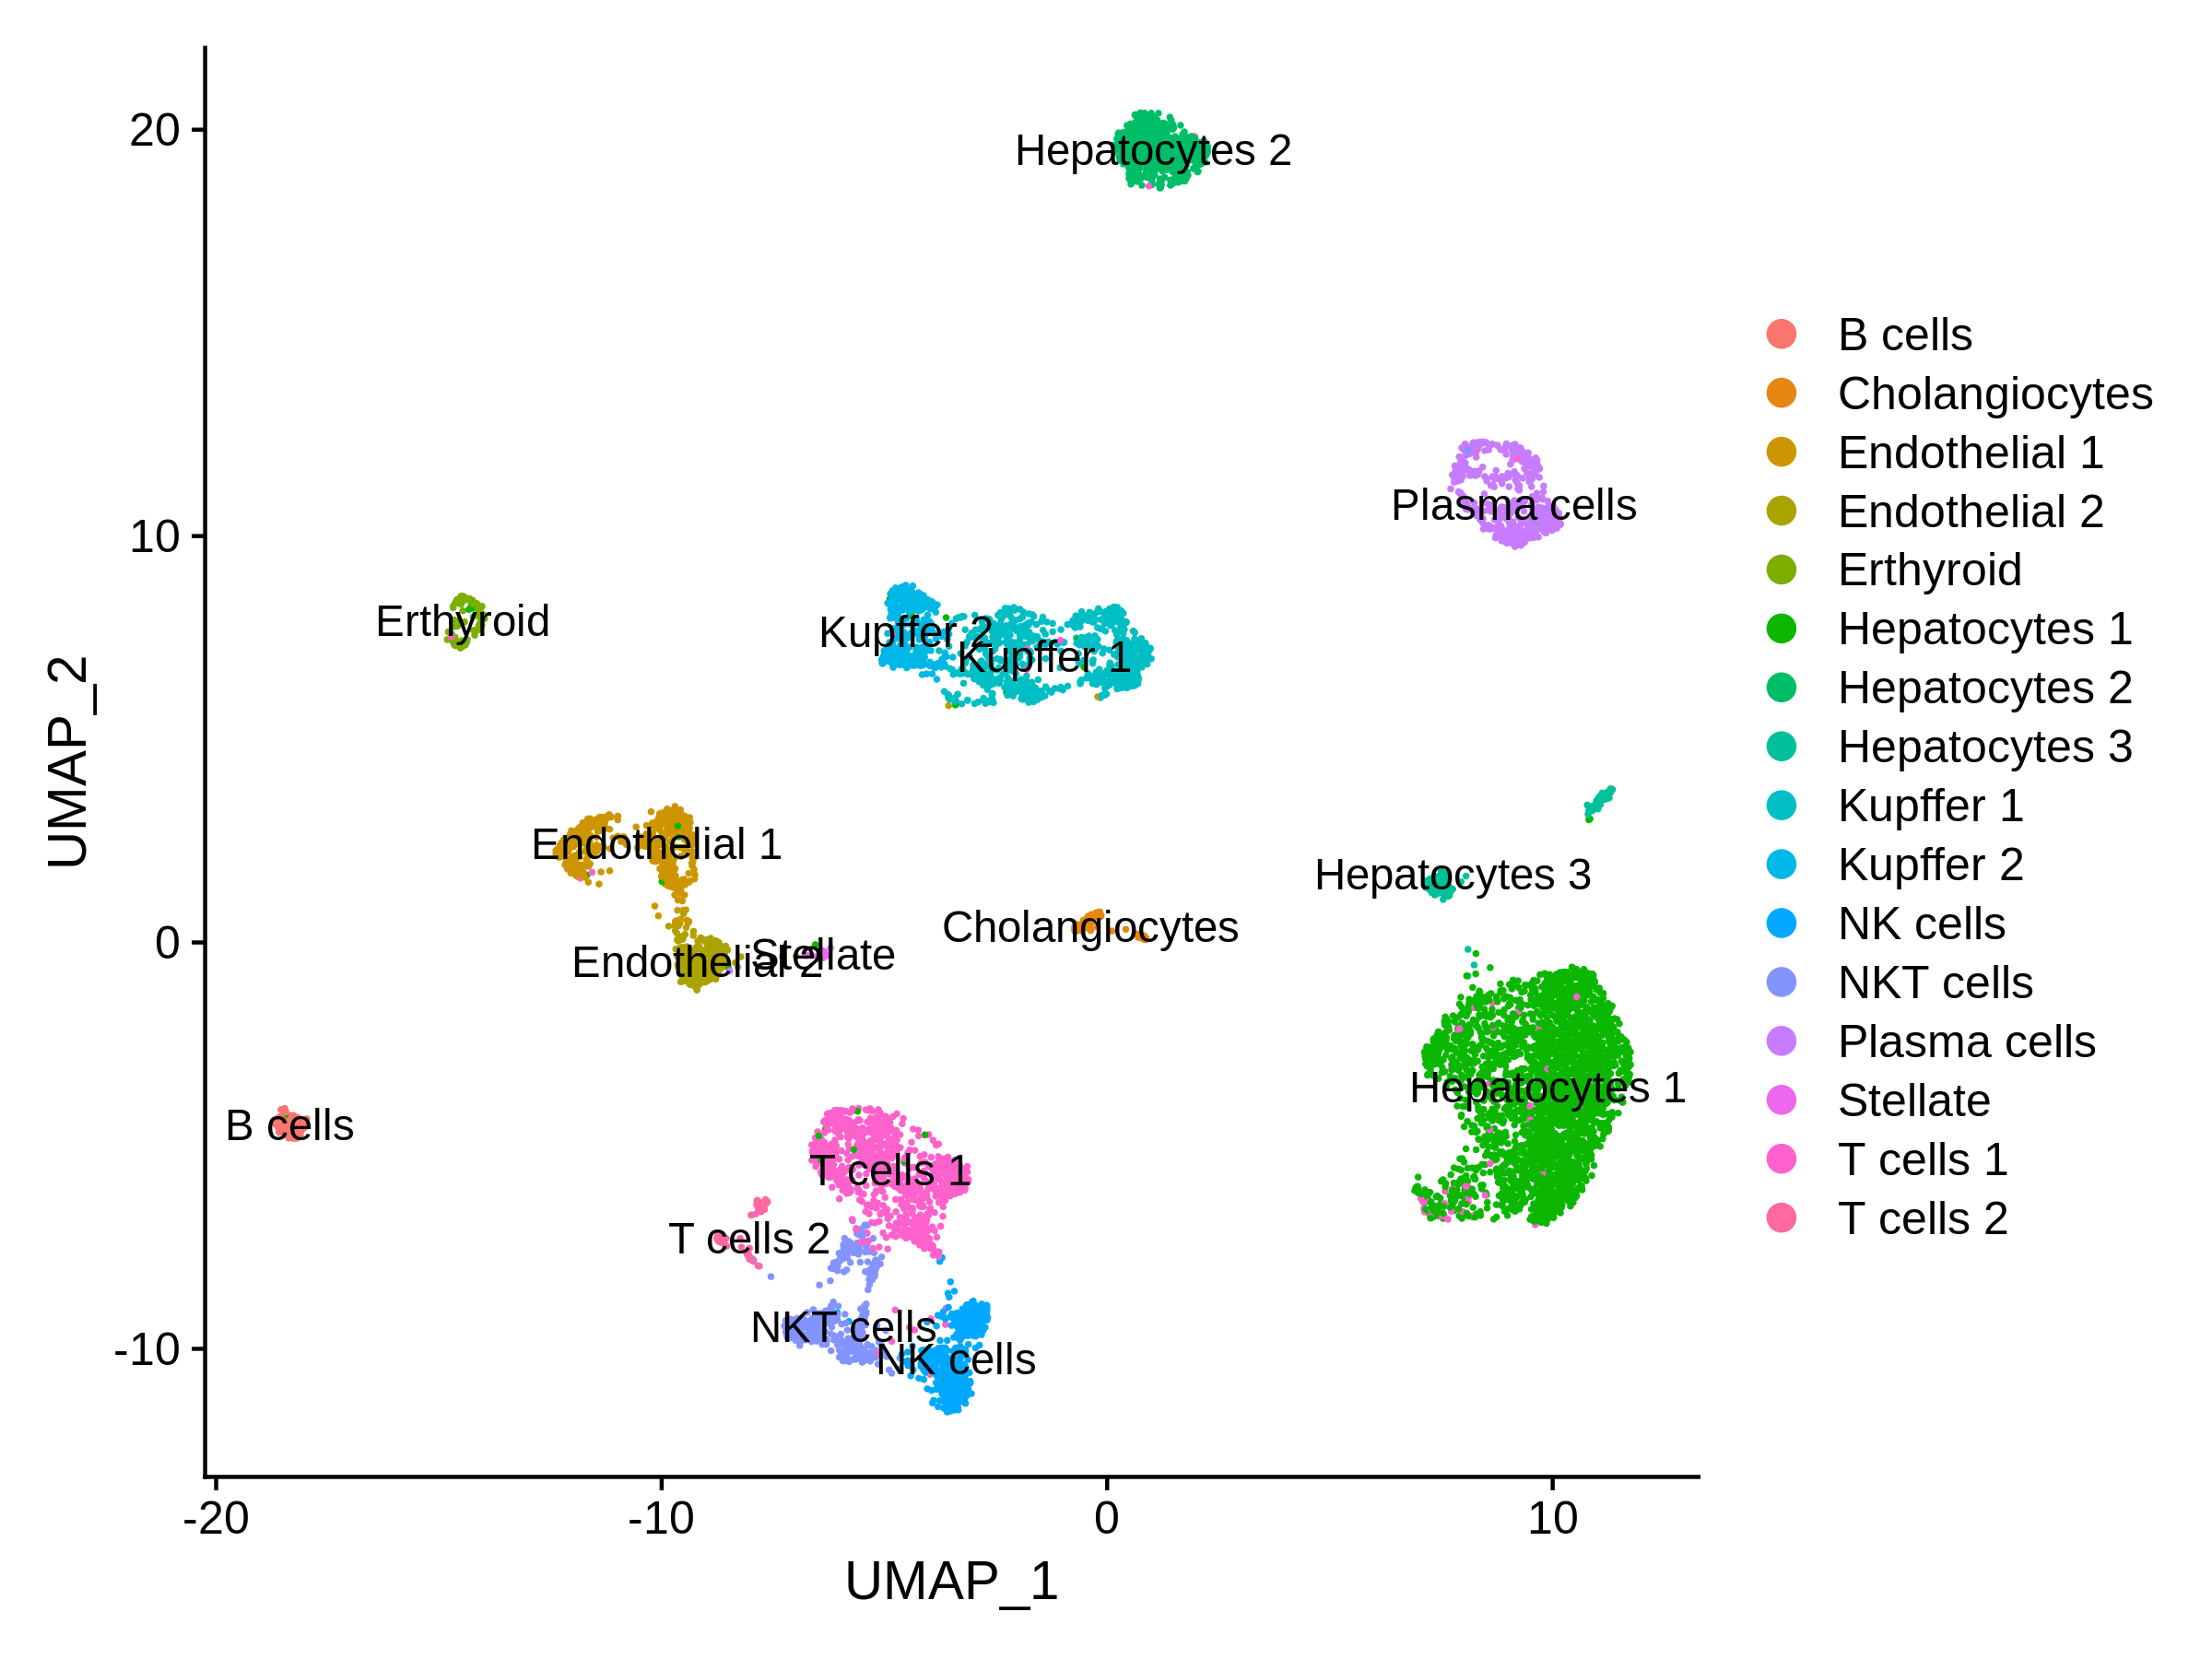

In [9]:
options(repr.plot.width=8, repr.plot.height=6, repr.plot.res=300)

DimPlot(liver, reduction = "umap", label = T, group = 'cluster')

### Extract meta data

In [10]:
meta.data = liver@meta.data

In [11]:
## take a look at the metadata
head(meta.data)

,Cell,nCount_RNA,nFeature_RNA,cluster,cluster_num
P1TLH_AAACCTGAGCAGCCTC_1,P1TLH_AAACCTGAGCAGCCTC_1,1633.605,1436,Endothelial 2,9
P1TLH_AAACCTGTCCTCATTA_1,P1TLH_AAACCTGTCCTCATTA_1,1439.645,2533,Cholangiocytes,12
P1TLH_AAACCTGTCTAAGCCA_1,P1TLH_AAACCTGTCTAAGCCA_1,1517.970,1030,Endothelial 2,9
P1TLH_AAACGGGAGTAGGCCA_1,P1TLH_AAACGGGAGTAGGCCA_1,1817.202,1808,Kupffer 1,2
P1TLH_AAACGGGGTTCGGGCT_1,P1TLH_AAACGGGGTTCGGGCT_1,1617.453,1428,T cells 1,1
P1TLH_AAAGCAACAGTAAGAT_1,P1TLH_AAAGCAACAGTAAGAT_1,2159.746,786,T cells 1,1


In [12]:
## Summarize the cell types in this dataset
celltype = data.frame(table(meta.data$cluster)) %>% arrange(desc(Freq))

celltype

Var1,Freq
Hepatocytes 1,2666
T cells 1,1040
Kupffer 1,836
Hepatocytes 2,637
Endothelial 1,520
Plasma cells,505
NK cells,498
NKT cells,443
Kupffer 2,347
Endothelial 2,289


### Use normalized UMI (NormUMI) as an example to show how to apply noise regularizationM


In [13]:
# Extract the log normalized UMI data from Seurat object
# transpose and convert to dense matrix
logNormUMI = GetAssayData(object = liver, assay = 'RNA', slot = 'data')

# Transform back Normalized UMI
norm.data = t(as.matrix(exp(logNormUMI)-1))

In [14]:
## take a look at the NormUMI data
norm.data[1:5,1:5]

,RP11-34P13.7,FO538757.2,AP006222.2,RP4-669L17.10,RP5-857K21.4
P1TLH_AAACCTGAGCAGCCTC_1,0,0,0.00000,0,0
P1TLH_AAACCTGTCCTCATTA_1,0,0,2.18637,0,0
P1TLH_AAACCTGTCTAAGCCA_1,0,0,0.00000,0,0
P1TLH_AAACGGGAGTAGGCCA_1,0,0,0.00000,0,0
P1TLH_AAACGGGGTTCGGGCT_1,0,0,0.00000,0,0


### In the noise regularization procedure, random noise will be generated based on the expression level of each gene. In the manuscript, the optimal noise level is between 1 percentile of the expression value. Here we will  calculate expression quantile for each gene

In [15]:
# Calculate quantile 
NormUMI.quantile.mat = calculate_quantile_matrix.bygene(m=norm.data,gene.names = NULL,expr.cell.list = NULL, quantile.list = c(seq(0.01,0.15,0.01),seq(0.2,0.7,0.1),seq(0.71,1,0.01)))


In [16]:
# Add a row of 0 quantile, equivalent to add no noise
NormUMI.quantile.mat = rbind(rep(0,ncol(NormUMI.quantile.mat)),rep(1,ncol(NormUMI.quantile.mat)),NormUMI.quantile.mat)
NormUMI.quantile.mat = rbind(rep(0,ncol(NormUMI.quantile.mat)),NormUMI.quantile.mat)

rownames(NormUMI.quantile.mat)[1] = c('add0')


In [17]:
# save quantile results
saveRDS(NormUMI.quantile.mat, paste0(out.dir,'/prepared.data/NormUMI.quantile.mat.allcell.rds'))


### Some genes are only expressed in a small number of cells. To get a more reliable gene-gene correlation inference, we will only keep genes expressed in more than 100 cells

### For each gene, calculate how many cell has non-zero expression in each cluster


In [18]:
gene.expr.count.by.cluster = apply(norm.data, 2, function(x){tapply(x,meta.data$cluster_num,function(y){sum(y>0)})})


In [19]:
gene.expr.count.by.cluster[1:5,1:5]

,RP11-34P13.7,FO538757.2,AP006222.2,RP4-669L17.10,RP5-857K21.4
0,1,164,54,9,3
1,4,91,15,2,0
10,1,36,11,2,0
11,0,10,0,0,0
12,0,18,7,0,0


In [20]:
# sum up the non-zero cells across all cell types
expr.sum = apply(gene.expr.count.by.cluster,2,sum)

In [21]:
## only keep genes expressing in >100 cells
gene.keep = names(expr.sum)[expr.sum>100]

In [22]:
norm.data = norm.data[,gene.keep]
gene.expr.count.by.cluster = gene.expr.count.by.cluster[,gene.keep]
NormUMI.quantile.mat = NormUMI.quantile.mat[,gene.keep]

In [23]:
# save the expression counts
saveRDS(gene.expr.count.by.cluster, paste0(out.dir,'/prepared.data/gene.mean.expr.count.by.cluster.rds'))

### Begin to perform noise regularization

In [24]:
all.genes = colnames(norm.data)
all.cells = rownames(norm.data)

In [25]:
# column name in meta data frame to indicate cell clusters, here we use the numbered cluster names
cluster_column = 'cluster_num'

In [26]:
# specify the outdir to save gene gene correlation results
out.dir.NormUMI = '/data4/users/ruoyu.zhang/project/internal_dev/gg_correlation/analysis/github.out/liver/NormUMI/'
dir.create(out.dir.NormUMI, recursive = T, showWarnings = F)

In [27]:
# for each cluster, adding different levels of noise (indicated by q.list)
# this step may take a few hours to finish
q.list = c('add0','1%')

# set a random seed
seed = 1

# begin to run gene gene correlation in cluster 0 to 7
for (i in 0:7){
  gc()
  message(paste('NormUMI',i))
  flush.console()
  take.gene = all.genes
  take.cells = rownames(meta.data)[meta.data[,cluster_column]==i]
  
  frac.0.15 = noise.regularization.cmp(m=norm.data[take.cells,],gene.list=all.genes, 
                                                    cuts = c(100,seq(500,10000,500)), max.low=0.1,
                                                    quantile.mat = NormUMI.quantile.mat,
                                      #quantile.list = c('1%'),
                                      quantile.list = q.list,
                                      string.data = string.data,title='NormUMI.bygene',
                                      out.dir=paste0(out.dir.NormUMI,'/cluster',i,'/'),ncore = 4,nblocks=30,seed = seed)
}

### Read gene gene correlaiton results, before and after Noise Regularization. Collect correlations from different clusters and pick up the max one as the final correlation for each gene pair

In [28]:
cor.dir = '/data4/users/ruoyu.zhang/project/internal_dev/gg_correlation/analysis/github.out/liver//NormUMI/'

In [29]:
cell.num = table(meta.data$cluster_num)


In [30]:
# Gene gene correlation before noise regularization
cor.df.add0 = pick.max.cluster(cor.dir=cor.dir,prefix='NormUMI',add='add0',clusters = 0:7, cell.num = cell.num, 
                 cell.per.cut = 0.01, min.cell.cut = 10,gene.count = gene.expr.count.by.cluster,prefix2='NormUMI')

# Gene gene correlation after noise regularization
cor.df.1p = pick.max.cluster(cor.dir=cor.dir,prefix='NormUMI',add='1p',clusters = 0:7, cell.num = cell.num, 
                 cell.per.cut = 0.01, min.cell.cut = 10,gene.count = gene.expr.count.by.cluster,prefix2='NormUMI')


In [31]:
# Save the results
saveRDS(cor.df.add0, file = paste0(out.dir, '/','NormUMI','.add0','.cor.df.rds'))

saveRDS(cor.df.1p, file = paste0(out.dir, '/','NormUMI','.1p','.cor.df.rds'))


### Evaluate the gene gene correlation results by the enrichment in PPI

### Load String information


In [32]:
string.data = readRDS('/data4/users/ruoyu.zhang/project/internal_dev/gg_correlation/STRING//human/9606.protein.links.full.v11.0.add.gene.name.rds')


In [34]:
cor.df.add0 = readRDS('/data4/users/ruoyu.zhang/project/internal_dev/gg_correlation/analysis/github.out/liver/NormUMI.add0.cor.df.rds')
cor.df.1p = readRDS('/data4/users/ruoyu.zhang/project/internal_dev/gg_correlation/analysis/github.out/liver/NormUMI.1p.cor.df.rds')

In [35]:
cor.max.add0.df = cor.df.add0 %>% select(pair_name,max)
colnames(cor.max.add0.df)[2] = 'spearman'

cor.max.1p.df = cor.df.1p %>% select(pair_name,max)
colnames(cor.max.1p.df)[2] = 'spearman'


In [36]:
max.1p.frac.df = ppi_frac_plot_rank(cor.df = cor.max.1p.df, cuts = c(100,seq(500,10000,500)),string.data = string.data,
                             title = '',type = '1p', do.plot = F)


In [37]:
max.add0.frac.df = ppi_frac_plot_rank(cor.df = cor.max.add0.df, cuts = c(100,seq(500,10000,500)),string.data = string.data,
                             title = '',type = 'add0', do.plot = F)


In [38]:
all.frac.df = rbind(max.1p.frac.df, max.add0.frac.df)

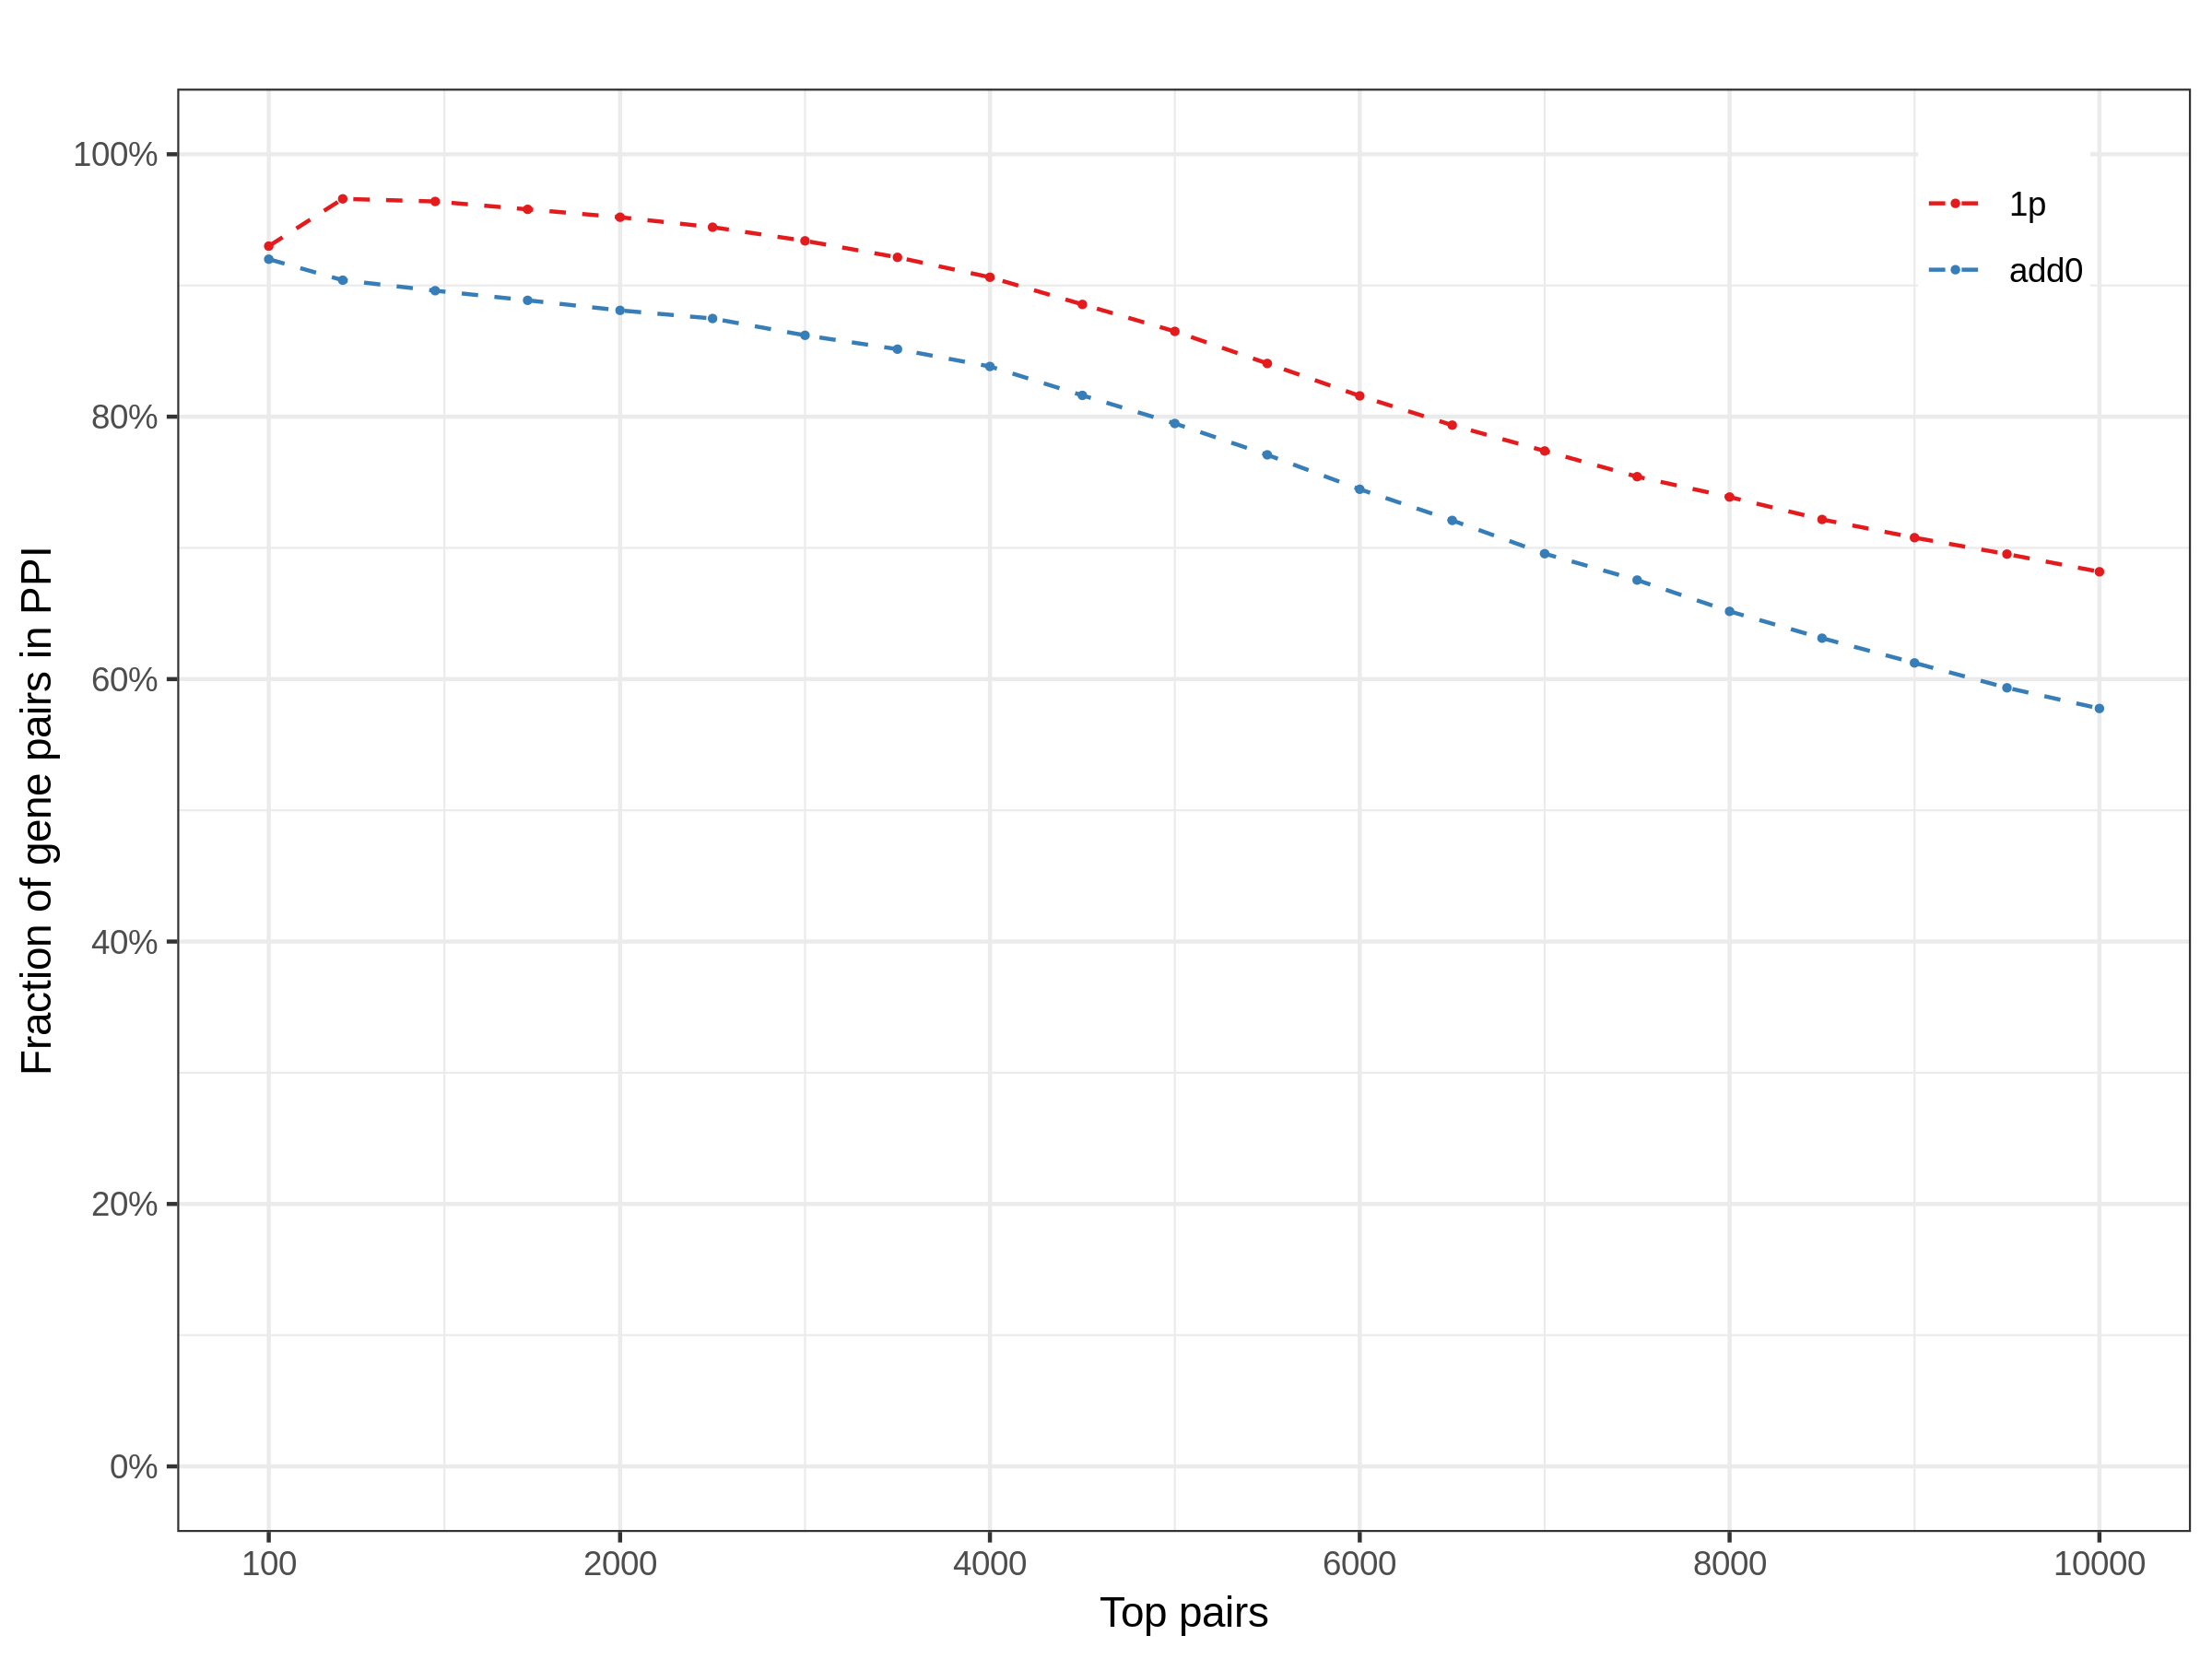

In [39]:
theme_set(theme_bw())
p=ggplot(all.frac.df, aes(cor.cut,in.ppi.frac,col=type)) + geom_point(size=I(0.5)) + geom_path(linetype = 'dashed')+
        scale_color_brewer(name='', palette='Set1')+scale_x_continuous(breaks = c(100,seq(2000,10000,2000))) + ylab('Fraction of gene pairs in PPI') + xlab('Top pairs')+
        scale_y_continuous(labels = scales::percent,limits = c(0,1),breaks=seq(0,1,0.2)) + 
        ggtitle('')+
 theme(legend.position = c(.95, 0.99),
    legend.justification = c("right", "top"),
    legend.box.just = "right",
    legend.margin = margin(1, 1, 1, 1))

p